In [1]:
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 여기에서 데이터 선택 -> 자동화 부탁

In [121]:
df = pd.read_csv('./merged_final.csv', index_col=0)

In [122]:
df.columns

Index(['date', 'air_GW', 'real_pop_GW', 'pop_GW', 'pop_male_GW',
       'pop_female_GW', 'mvpop_GW', 'station_GW', 'air_DDM', 'real_pop_DDM',
       'pop_DDM', 'pop_male_DDM', 'pop_female_DDM', 'mvpop_DDM', 'station_DDM',
       'air_SD', 'real_pop_SD', 'pop_SD', 'pop_male_SD', 'pop_female_SD',
       'mvpop_SD', 'station_SD', 'air_JL', 'real_pop_JL', 'pop_JL',
       'pop_male_JL', 'pop_female_JL', 'mvpop_JL', 'station_JL',
       'keyword_diet', 'keyword_exercise', 'keyword_healthypleasure',
       'keyword_environment', 'keyword_green', 'keyword_dust', 'keyword_',
       'temp_avg', 'temp_low', 'temp_high', 'rain(mm)', 'relative_humidity',
       'distance_stage', 'distance_total', 'distance_value',
       'distance_nominal', 'GW_demand', 'DDM_demand', 'SD_demand',
       'JL_demand'],
      dtype='object')

In [123]:
df_sliced = df[['air_GW', 'real_pop_GW', 'pop_GW', 'pop_male_GW', 'pop_female_GW',
       'mvpop_GW', 'station_GW', 'GW_demand']]

In [124]:
train_set = df_sliced.iloc[:1096]
test_set = df_sliced.iloc[1096:]

In [125]:
from sklearn.preprocessing import MinMaxScaler

In [126]:
#여기에서 MinMaxScaler() 다른 거로 변경 가능

# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1] = scaler_y.transform(train_set.iloc[:, [-1]])
test_set.iloc[:, -1] = scaler_y.transform(test_set.iloc[:, [-1]])

In [127]:
train_set

,air_GW,real_pop_GW,pop_GW,pop_male_GW,pop_female_GW,mvpop_GW,station_GW,GW_demand
0,0.212291,0.717598,1.0,0.0,1.0,0.297793,0.0,0.046099
1,0.217877,0.582668,1.0,0.0,1.0,0.679800,0.0,0.065410
2,0.167598,0.563368,1.0,0.0,1.0,0.692870,0.0,0.064476
3,0.223464,0.594071,1.0,0.0,1.0,0.697588,0.0,0.061673
4,0.335196,0.590225,1.0,0.0,1.0,0.766890,0.0,0.063697
...,...,...,...,...,...,...,...,...
1091,0.318436,0.364665,0.0,1.0,0.0,0.001270,1.0,0.274724
1092,0.307263,0.289632,0.0,1.0,0.0,0.329940,1.0,0.353683
1093,0.301676,0.276752,0.0,1.0,0.0,0.334194,1.0,0.287650
1094,0.156425,0.300122,0.0,1.0,0.0,0.347221,1.0,0.184239


In [128]:
# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 7
batch = 100

In [129]:
# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

In [130]:
# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

In [131]:
# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

In [132]:
# 설정값
data_dim = 8
hidden_dim = 10 
output_dim = 1 
learning_rate = 0.01
nb_epochs = 500

class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [133]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.L1Loss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

In [134]:
# 모델 학습
device = torch.device('cpu')
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

Epoch: 0000 train loss : 0.1965
Epoch: 0020 train loss : 0.0870
Epoch: 0040 train loss : 0.0840
Epoch: 0060 train loss : 0.0820

 Early Stopping


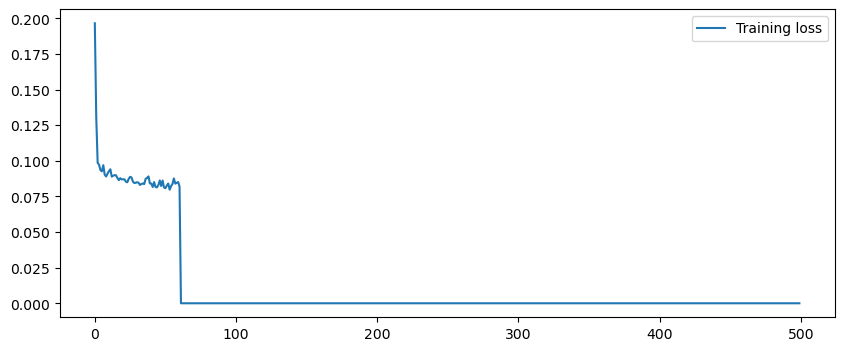

In [135]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [136]:
# 모델 저장    
PATH = "./LSTM_model.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

Net(
  (lstm): LSTM(8, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [160]:
# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

MAE SCORE :  2.702255906697831


In [237]:
testY_tensor

tensor([[0.0592],
        [0.0704],
        [0.0782],
        [0.1414],
        [0.0936],
        [0.1442],
        [0.2380],
        [0.2442],
        [0.1646],
        [0.1280],
        [0.1332],
        [0.1953],
        [0.2654],
        [0.1402],
        [0.2616],
        [0.3032],
        [0.3770],
        [0.4083],
        [0.1827],
        [0.3286],
        [0.1724],
        [0.1816],
        [0.1984],
        [0.2996],
        [0.3035],
        [0.2433],
        [0.2356],
        [0.1604],
        [0.3004],
        [0.3353],
        [0.2766],
        [0.2504],
        [0.3054],
        [0.3465],
        [0.2708],
        [0.3026],
        [0.4107],
        [0.3680],
        [0.2515],
        [0.1789],
        [0.1774],
        [0.2383],
        [0.3414],
        [0.5009],
        [0.6119],
        [0.4398],
        [0.3538],
        [0.4322],
        [0.4194],
        [0.5585],
        [0.6297],
        [0.5294],
        [0.0276],
        [0.3867],
        [0.4921],
        [0

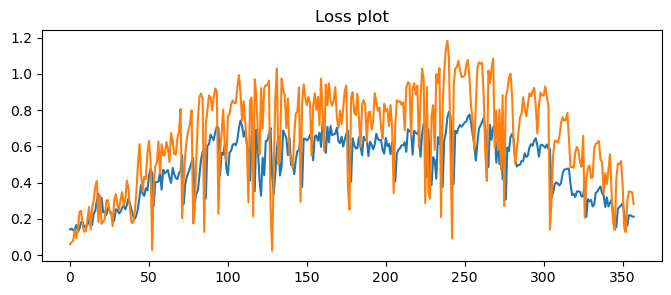

In [138]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred)), pred, label = 'pred')
plt.plot(np.arange(len(testY)), testY, label = 'true')
plt.title("Loss plot")
plt.show()

# Submission

In [225]:
test_df = pd.read_csv('./open/sample_submission.csv')
test_df_sliced = test_df[['광진구']]
test_df_sliced = test_df_sliced.rename(columns={'광진구':'GW_demand'})

In [226]:
test_df_sliced[['air_GW', 'real_pop_GW', 'pop_GW', 'pop_male_GW', 'pop_female_GW',
       'mvpop_GW', 'station_GW']] = 0

In [227]:
test_df_sliced = test_df_sliced[['air_GW', 'real_pop_GW', 'pop_GW', 'pop_male_GW', 'pop_female_GW',
       'mvpop_GW', 'station_GW', 'GW_demand']]

In [228]:
test_df_sliced = pd.concat([test_set[seq_length*(-1):], test_df_sliced]).reset_index().drop(columns='index')

In [229]:
test_df_sliced

,air_GW,real_pop_GW,pop_GW,pop_male_GW,pop_female_GW,mvpop_GW,station_GW,GW_demand
0,0.100559,0.280649,-0.60218,1.083068,-0.45687,0.244715,1.195122,0.151534
1,0.061453,0.298820,-0.60218,1.083068,-0.45687,0.129463,1.195122,0.126149
2,0.106145,0.226884,-0.60218,1.083068,-0.45687,0.451440,1.195122,0.298240
3,0.212291,0.221541,-0.60218,1.083068,-0.45687,0.484266,1.195122,0.351191
4,0.279330,0.219172,-0.60218,1.083068,-0.45687,0.509474,1.195122,0.349634
...,...,...,...,...,...,...,...,...
336,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
337,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
338,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
339,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000


In [212]:
test_df_sliced = test_df_sliced[['GW_demand']]

In [251]:
def inference(model, df, device):
    model.to(device)
    model.eval()
    for i in tqdm(range(seq_length, len(df))): #7부터 데이터 끝까지
        X = torch.Tensor(np.array(df.loc[i-seq_length:i-1, ['air_GW', 'real_pop_GW', 'pop_GW', 'pop_male_GW', 'pop_female_GW',
       'mvpop_GW', 'station_GW', 'GW_demand']]).astype(float)).unsqueeze(0)
        X = X.to(device)
        with torch.no_grad():
            model_pred = model(X)[0]
            print(model_pred)
            #model_pred_np = scaler_y.inverse_transform(model_pred.reshape(-1, 1))
        
        model_pred = model_pred.cpu().numpy()
        
        #scaler_y.inverse_transform(X)
        
        df.loc[i, ['air_GW', 'real_pop_GW', 'pop_GW', 'pop_male_GW', 'pop_female_GW',
       'mvpop_GW', 'station_GW', 'GW_demand']] = model_pred
        
    return df.loc[seq_length:, ['GW_demand']].reset_index().drop(columns=['index'])

In [252]:
preds = inference(model, test_df_sliced, device)

  0%|          | 0/334 [00:00<?, ?it/s]

tensor([0.1885])
tensor([0.2818])
tensor([0.2819])
tensor([0.2981])
tensor([0.3118])
tensor([0.3240])
tensor([0.3327])
tensor([0.3401])
tensor([0.3484])
tensor([0.3545])
tensor([0.3601])
tensor([0.3653])
tensor([0.3700])
tensor([0.3743])
tensor([0.3782])
tensor([0.3819])
tensor([0.3852])
tensor([0.3884])
tensor([0.3913])
tensor([0.3941])
tensor([0.3967])
tensor([0.3992])
tensor([0.4016])
tensor([0.4038])
tensor([0.4059])
tensor([0.4080])
tensor([0.4099])
tensor([0.4118])
tensor([0.4136])
tensor([0.4153])
tensor([0.4170])
tensor([0.4187])
tensor([0.4202])
tensor([0.4218])
tensor([0.4233])
tensor([0.4247])
tensor([0.4262])
tensor([0.4276])
tensor([0.4289])
tensor([0.4303])
tensor([0.4316])
tensor([0.4329])
tensor([0.4342])
tensor([0.4354])
tensor([0.4367])
tensor([0.4379])
tensor([0.4391])
tensor([0.4403])
tensor([0.4415])
tensor([0.4427])
tensor([0.4439])
tensor([0.4451])
tensor([0.4463])
tensor([0.4474])
tensor([0.4486])
tensor([0.4498])
tensor([0.4510])
tensor([0.4521])
tensor([0.4533

# Submission

In [202]:
submit = pd.read_csv('./open/sample_submission.csv')
submit.head()

,일시,광진구,동대문구,성동구,중랑구
0,20220101,0,0,0,0
1,20220102,0,0,0,0
2,20220103,0,0,0,0
3,20220104,0,0,0,0
4,20220105,0,0,0,0


In [253]:
submit['광진구'] = preds['GW_demand'].round(3)

In [254]:
submit.head(20)

,일시,광진구,동대문구,성동구,중랑구
0,20220101,0.188,0,0,0
1,20220102,0.282,0,0,0
2,20220103,0.282,0,0,0
3,20220104,0.298,0,0,0
4,20220105,0.312,0,0,0
5,20220106,0.324,0,0,0
6,20220107,0.333,0,0,0
7,20220108,0.340,0,0,0
8,20220109,0.348,0,0,0
9,20220110,0.355,0,0,0
